In [0]:
!pip install optuna
!pip install featuretools
!pip install heamy

In [0]:
!unzip titanic.zip

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier 
from xgboost import XGBClassifier

In [18]:

'''
データのロード
'''
train = pd.read_csv("train.csv")      # (891, 12)
test = pd.read_csv("test.csv")        # (418, 11)

full_data = pd.concat([train,test])

train_len = len(train)      # 891
test_len = len(test)        # 418

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




In [0]:
def missing_table(df):      # データの欠損を計算
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    missing_table_ren_columns = missing_table.rename(
        columns = {0:"欠損数", 1:"%"}
    )
    return missing_table_ren_columns

# print(missing_table(train))
# print(missing_table(test))

In [20]:
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [0]:
'''
データの前処理
'''
# 欠損値の補正
test["Fare"] = test["Fare"].fillna(test["Fare"].median())
train['Embarked'] = train['Embarked'].fillna('S')
# full_data["Fare"] = full_data["Fare"].fillna(full_data["Fare"].median())
# full_data['Embarked'] = full_data['Embarked'].fillna('S')

# 名前の敬称を抽出
for i in range(len(train)):
  train["Name"][i] = train["Name"][i].split('.')[0].split(', ')[1]
for i in range(len(test)):
  test["Name"][i] = test["Name"][i].split('.')[0].split(', ')[1]
# for i in range(len(full_data)):
#   full_data["Name"][i] = full_data["Name"][i].split('.')[0].split(', ')[1]
full_data = pd.concat([train,test])

# 家族数を計算
# train['family'] = train['SibSp'] + train['Parch']
# test['family'] = test['SibSp'] + test['Parch']
full_data['family'] = full_data['SibSp'] + full_data['Parch']

# ダミーデータを生成
def add_dummy(df):
    df['Pclass'] = df['Pclass'].astype(np.str)
    temp = pd.get_dummies(df[['Sex','Embarked','Pclass','Name']], drop_first = False)
    temp['PassengerId'] = df['PassengerId']
    return pd.merge(df, temp)
# train = add_dummy(train)
# test = add_dummy(test)
full_data = add_dummy(full_data)

In [0]:
x_train.shape

(891, 30)

In [0]:
x_train_map = full_data[:len(train)].drop(columns=['PassengerId','Name','Sex', 'Ticket','Embarked','Age','Cabin','Pclass'])
x_train = full_data[:len(train)].drop(columns=['Survived', 'PassengerId','Name','Sex', 'Ticket','Embarked','Age','Cabin','Pclass'])
x_test = full_data[len(train):].drop(columns=['Survived','PassengerId','Name','Sex', 'Ticket','Embarked','Age','Cabin','Pclass'])
y_train = full_data[:len(train)]['Survived']

# x_train_demo = full_data.loc[:,[
#     'family',
#     'Fare',
#     'Sex_female',
#     'Sex_male',
#     'Pclass_1',
#     'Pclass_3',
#     'Name_Miss',
#     'Name_Mr'
# ]]
# x_train_demo = x_train_demo[:len(train)]
# x_test_demo = full_data.loc[:,[
#     'family',
#     'Fare',
#     'Sex_female',
#     'Sex_male',
#     'Pclass_1',
#     'Pclass_3',
#     'Name_Miss',
#     'Name_Mr'
# ]]
# x_test_demo = x_test_demo[len(train):]

In [0]:
list_p_value

In [0]:
corrmat = x_train_map.corr()
f, ax = plt.subplots(figsize=(20,12))
sns.heatmap(corrmat, vmax=.8, annot = True, center = 0)

In [0]:
'''
特徴量の選択
'''
from boruta_py import BorutaPy

model = RandomForestClassifier(max_depth=5)
feat_selector = BorutaPy(
    model,
    n_estimators='auto',
    two_step= True,
    verbose=2,
    random_state=42,
    perc=80,
    max_iter=100
)

In [0]:
feat_selector.fit(x_train.values, y_train.values)

In [0]:
x_train_selected = x_train.iloc[:,feat_selector.support_]
x_test_selected = x_test.iloc[:,feat_selector.support_]

In [0]:
data_s = pd.concat([x_train_selected, y_train], axis=1)
data_s = data_s.sample(frac=1)
x_train_selected_s = data_s.drop(columns=['Survived'])
y_train_selected_s = data_s['Survived']

In [0]:
(x_train_selected_input, x_val, y_train_selected_input, y_val) = train_test_split(x_train_selected, y_train, test_size=0.3, random_state=666)       # random_stateのseedを適当に固定
# (x_train_demo_input, x_val, y_train_demo_input, y_val) = train_test_split(x_train_demo, y_train, test_size=0.3, random_state=666)       # random_stateのseedを適当に固定

In [0]:
# k分割交差検証
from sklearn.model_selection import cross_val_score

def kfold(model, x, y, cv):
  data_s = pd.concat([x, y], axis=1)
  data_s = data_s.sample(frac=1)
  x_s = data_s.drop(columns=['Survived'])
  y_s = data_s['Survived'].as_matrix()
  scores = cross_val_score(model, x_s, y_s, cv=cv)
  print('Cross-Validation scores: {}'.format(scores))
  print('Average score: {}'.format(np.mean(scores)))
  return float(format(np.mean(scores)))

In [0]:
'''
モデルの構築(xgBoost)
'''
model_xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)
model_xgb.fit(x_train_selected_input, y_train_selected_input)
# model_xgb.fit(x_train_demo_input, y_train_demo_input)


In [0]:
'''
モデルの構築(gBoost)
'''
model_gb = GradientBoostingClassifier(random_state=0)
model_gb.fit(x_train_selected_input, y_train_selected_input)
# model_gb.fit(x_train_demo_input, y_train_demo_input)

In [0]:
'''
モデルの構築(RF_gini)
'''
model_rf_gini = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=0)
# model_rf_gini.fit(x_train_selected_input, y_train_selected_input)
# model_rf_gini.fit(x_train_demo_input, y_train_demo_input)

In [0]:
'''
モデルの構築(RF_entropy)
'''
model_rf_entropy = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)
# model_rf_entropy.fit(x_train_selected_input, y_train_selected_input)
# model_rf_entropy.fit(x_train_demo_input, y_train_demo_input)

In [332]:
'''
モデルの構築(Stacking)
'''
from heamy.dataset import Dataset
from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
from sklearn.linear_model import LinearRegression

data_s = pd.concat([x_train_selected, y_train], axis=1)
data_s = data_s.sample(frac=1)
x_s = data_s.drop(columns=['Survived'])
y_s = data_s['Survived'].as_matrix()
(x_s, x_val, y_s, y_val) = train_test_split(x_s, y_s, test_size=0.3, random_state=666)

dataset = Dataset(x_s, y_s, x_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



In [0]:
# アンサンブルに使うモデルの定義
models = [
    Regressor(dataset=dataset, estimator=RandomForestClassifier, parameters={'n_estimators': 100, 'random_state': 0, 'criterion':'gini'}, name='rf_gini'),
    Regressor(dataset=dataset, estimator=RandomForestClassifier, parameters={'n_estimators': 100, 'random_state': 0, 'criterion':'entropy'}, name='rf_entropy'),
    Regressor(dataset=dataset, estimator=XGBClassifier, parameters={'max_depth':3, 'learning_rate':0.1, 'n_estimators':100}, name='xgb'),
    Regressor(dataset=dataset, estimator=GradientBoostingClassifier, name='gb')
]

In [0]:
# pipelineを定義、2nd levelデータセットの作成
pipeline = ModelsPipeline(*models)
stack_ds = pipeline.stack(k=10, seed=0)

In [0]:
# modelを作ってvalidation
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
y_trues, y_preds = stacker.validate(k=10)

In [0]:
pred_stacker = stacker.predict()

In [0]:
pred_stacker = np.round(pred_stacker).astype(int)

In [343]:
'''
評価
'''
print("Accuracy_v:",accuracy_score(pred_stacker, y_val))

Accuracy_v: 0.835820895522388


In [0]:
print('XGB')
prev_xgb = kfold(model_xgb, x_train_selected, y_train, 10)
print('-'*150)
print('GB')
prev_gb = kfold(model_gb, x_train_selected, y_train, 10)
print('-'*150)
print('RF_gini')
prev_rf_gini = kfold(model_rf_gini, x_train_selected, y_train, 10)
print('-'*150)
print('RF_entropy')
prev_rf_entropy = kfold(model_rf_entropy, x_train_selected, y_train, 10)


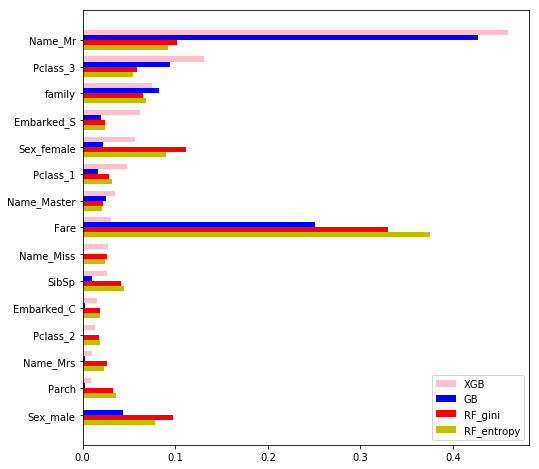

In [33]:
'''
変数重要度の可視化
'''
import matplotlib.pyplot as plt

features = x_train_selected_input.columns
# features = x_train_demo_input.columns

importances_xgb = model_xgb.feature_importances_
indices_xgb = np.argsort(importances_xgb)
importances_gb = model_gb.feature_importances_
indices_gb = np.argsort(importances_gb)
importances_rf_gini = model_rf_gini.feature_importances_
indices_rf_gini = np.argsort(importances_rf_gini)
importances_rf_entropy = model_rf_entropy.feature_importances_
indices_rf_entropy = np.argsort(importances_rf_entropy)

height=24
wide=128

left = np.arange(len(indices_xgb))*wide


# print('XGB')
plt.figure(figsize=(8,8))
plt.barh(left+height*3/2, importances_xgb[indices_xgb], color='pink', align='center', height=height, label="XGB")
plt.yticks(range(0,len(indices_xgb)*wide, wide), features[indices_xgb])

# print('GB')
plt.barh(left+height/2, importances_gb[indices_xgb], color='b', align='center', height=height, label="GB")
plt.yticks(range(0,len(indices_xgb)*wide, wide), features[indices_xgb])

# print('RF_gini')
plt.barh(left-height/2, importances_rf_gini[indices_xgb], color='r', align='center', height=height, label="RF_gini")
plt.yticks(range(0,len(indices_xgb)*wide, wide), features[indices_xgb])

# print('RF_entropy')
plt.barh(left-height*3/2, importances_rf_entropy[indices_xgb], color='y', align='center', height=height, label="RF_entropy")
plt.yticks(range(0,len(indices_xgb)*wide, wide), features[indices_xgb])
plt.legend()
plt.show()



In [7]:
!pip install pandas scikit-learn scipy

In [0]:
'''
提出
'''
from datetime import datetime, timedelta, timezone
JST = timezone(timedelta(hours=+9), 'JST')
ts = datetime.now(JST).strftime('%y%m%d%H%M')

y_test = model_gb.predict(x_test_selected)

test["Survived"] = y_test.astype(np.int)
test[["PassengerId","Survived"]].to_csv(('submit_'+ts+'_gb.csv'),index=False)